# MAESTRO piano MIDI file analysis

Import Libraries

In [95]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import soundfile as sf
import sklearn
from statistics import mean
import numpy as np
import pandas as pd
import scipy.stats
import mido
from sklearn.metrics import confusion_matrix as confmat
import seaborn as sns

File access exploration

In [96]:
# Import metadata file as dataframe
maestro_metadata = pd.read_csv("MAESTRO metadata expanded3.csv")
print(maestro_metadata.head())

# Convert minor eras to major eras if not already done
maestro_eras = pd.read_csv("MAESTRO eras.csv")
major_eras = [maestro_eras['Index2'][i] for i in maestro_metadata['era index']]
maestro_metadata['era index2'] = major_eras
maestro_metadata.to_csv("MAESTRO metadata expanded3.csv")
eracomp = confmat(maestro_metadata['era index'],maestro_metadata['era index2'])

# extract MIDI file paths into a list
fullpaths = []
basepath = "C:\\Personal Projects\\maestro-v3.0.0\\"
for index, row in maestro_metadata.iterrows():
    fullpaths.append(basepath+row["midi_filename"].replace("/","\\"))

print(len(fullpaths))
print(fullpaths[1000:1001])


   Unnamed: 0  canonical_composer second composer  \
0           0         Alban Berg              NaN   
1           1         Alban Berg              NaN   
2           2         Alban Berg              NaN   
3           3  Alexander Scriabin             NaN   
4           4  Alexander Scriabin             NaN   

                 canonical_title       split  year  \
0                   Sonata Op. 1       train  2018   
1                   Sonata Op. 1       train  2008   
2                   Sonata Op. 1       train  2017   
3  24 Preludes Op. 11, No. 13-24       train  2004   
4               3 Etudes, Op. 65  validation  2006   

                                       midi_filename  \
0  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...   
1  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...   
2  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...   
3  2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...   
4  2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...   

                   

Extract some summary statistics from the metadata

In [4]:
# Count of performances by composer
pop_composers = maestro_metadata.groupby(by=["canonical_composer"])["canonical_composer"].count().sort_values(ascending=False)
print(pop_composers[0:5])

# Count of performances by year
pop_years = maestro_metadata.groupby(by=["year"])["year"].count()
#print(pop_years)

# Top-5 composers by year
yearlist = maestro_metadata["year"].unique()
for y in yearlist:
  top_composers = maestro_metadata[maestro_metadata["year"]==y].groupby(by=["canonical_composer"])["canonical_composer"].count().sort_values(ascending=False)
  #print(top_composers[0:3])

top_composers = maestro_metadata.groupby(by=["canonical_composer"])["canonical_composer"].count().sort_values(ascending=False)
#print(top_composers[0:5])

# Count of performances by nationality
pop_nation = maestro_metadata.groupby(by=["nationality"])["nationality"].count().sort_values(ascending=False)
print(pop_nation)

# Eras of composition by performance year (%)
top_eras = maestro_metadata.groupby(by=["era"])["era"].count().sort_values(ascending=False)
print(top_eras)


canonical_composer
Frédéric Chopin           201
Franz Schubert            197
Johann Sebastian Bach     156
Ludwig van Beethoven      146
Franz Liszt               134
Name: canonical_composer, dtype: int64
nationality
German            412
Austrian          280
Polish-French     201
Hungarian         134
Russian           128
French             54
Italian            39
Spanish             8
German-British      5
Unknown             5
Czech               4
Norwegian           3
British             1
English             1
Romanian            1
Name: nationality, dtype: int64
era
Early Romantic                   422
Classical-Romantic Transition    345
Late Baroque                     195
Post Romantic                    155
Middle Romantic                   45
Late Classical                    44
Middle Classical                  41
Late Romantic                     22
Modernist                          4
Early Baroque                      1
Early Galante                      1
Moderni

Demonstrate MIDI access

In [5]:
from mido import MidiFile
from mido import MetaMessage
from mido import tempo2bpm

songs = []

# for files in the path list
for i in range(len(fullpaths)):

  if i%50 == 0:
    print("Processing file",i)

  midipath = "MIDIextracts\\"+str(i)+".csv"

  songdict = {"notes":[],"vels":[],"times":[]}
  mid = MidiFile(fullpaths[i])

  # collect all the note messages, ignoring the control ones
  for msg in mid.tracks[1]:
    if msg.type == "note_on":
      songdict["notes"].append(msg.note)
      songdict["vels"].append(msg.velocity)
      songdict["times"].append(msg.time)
    elif msg.type not in ["control_change","program_change","end_of_track","track_name"]:
      print("Found unusual message:",msg.type)

  # convert the song to dataframe and write out to a unique CSV file
  songdf = pd.DataFrame(songdict)
  songdf.to_csv(midipath)




Processing file 0
Processing file 50
Processing file 100


KeyboardInterrupt: 

Develop metrics based on MIDI data:
- Notes --> keys & complexity
- Times --> tempo & complexity
- Velocities --> dynamic complexity

Run through each file and collect active notes, start times, and durations

In [6]:

# function to analyze a CSV-encoded list of MIDI note on and off messages
# and return the summed durations of each note
def extract_MIDI(targetfile,verbose=False):

  song = pd.read_csv(targetfile,dtype='int32')
  # dictionary of currently played notes, with time they were started
  activenotes = {}
  # table of total durations of each note during the piece
  pastdurs = np.zeros(128)

  if verbose:
    maxnote = song["notes"].max(axis=0)
    minnote = song["notes"].min(axis=0)
    print("Song contains",len(song),"note events between",minnote,"-",maxnote)
    print("Sample opening notes:")

  # first note special handline
  note = song.iloc[0]
  t = 0
  n = note["notes"]
  v = note["vels"]
  if v > 0:
    activenotes[n] = t

  for i in range(1,len(song)):
    note = song.iloc[i]
    n = note["notes"]
    v = note["vels"]
    t = note["times"] + t
    if v > 0:
      activenotes[n] = t
    elif v == 0:
      if n in activenotes:
        t1 = activenotes.pop(n,None)
        dur = t - t1
        pastdurs[n] += dur

    if verbose and i<=5:
      print(activenotes)
  
  sumdurs = np.sum(pastdurs)
  pastdurs = pastdurs/sumdurs
  # return the fingerprint of durations
  return pastdurs
  
# analyze a sample file
targetfile = "MIDIextracts\\131.csv"
song131durs = extract_MIDI(targetfile,verbose=True)

outputfile = "MIDIextracts\\131_durs.csv"
songdursdf = pd.DataFrame(song131durs)
songdursdf.to_csv(outputfile)


Song contains 15314 note events between 26 - 101
Sample opening notes:
{69: 0, 50: 3}
{69: 0, 50: 3, 62: 15}
{69: 0, 50: 3, 62: 15, 65: 25}
{69: 0, 50: 3, 65: 25}
{69: 0, 50: 3, 65: 25, 60: 337}


Extract duration info from all files

In [165]:
# loop through all files
for i in range(len(fullpaths)):

  if i%50 == 0:
    print("Processing file",i)

  targetfile = "MIDIextracts\\"+str(i)+".csv"
  songdurs = extract_MIDI(targetfile,verbose=False)

  outputfile = "MIDIextracts\\"+str(i)+"_durs.csv"
  songdursdf = pd.DataFrame(songdurs)
  songdursdf.to_csv(outputfile)


Processing file 0
Processing file 50
Processing file 100
Processing file 150
Processing file 200
Processing file 250
Processing file 300
Processing file 350
Processing file 400
Processing file 450
Processing file 500
Processing file 550
Processing file 600
Processing file 650
Processing file 700
Processing file 750
Processing file 800
Processing file 850
Processing file 900
Processing file 950
Processing file 1000
Processing file 1050
Processing file 1100
Processing file 1150
Processing file 1200
Processing file 1250


Plot a sample duration file, convert to 12 tones, 
  and reharmonize so that the dominant note is the 1st scale tone

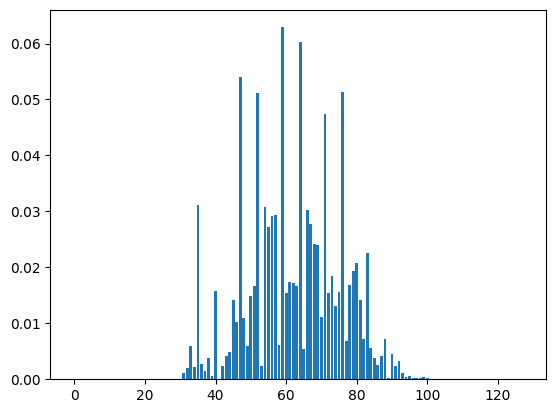

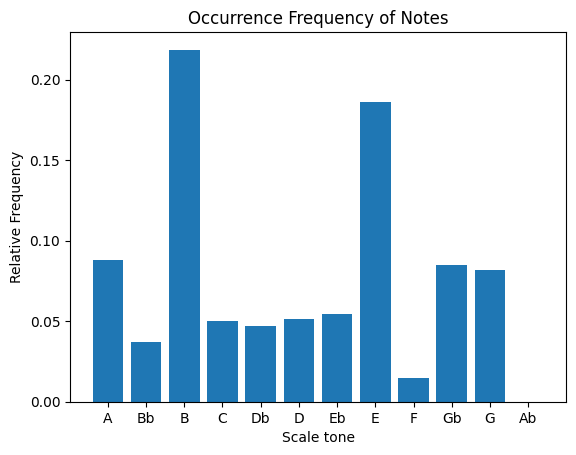

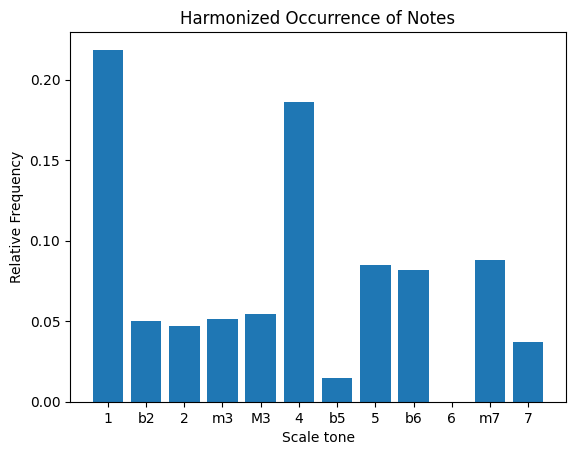

In [8]:
# plot a sample file
targetfile = "MIDIextracts\\128_durs.csv"
songdurs = pd.read_csv(targetfile,dtype=float)
songdurs = songdurs["0"]

plt.bar(range(128),songdurs)
plt.show()


def collapse_12tones(inputdf):
  df_12tones = np.zeros(12)
  for i in range(21,128,12):
      df_12tones[0:11]+=inputdf[i:i+11]
  return df_12tones

def recenter_12tones(inputdf):
  ctr_df = np.zeros(12)
  key = np.argmax(inputdf)

  ctr_df[0:(12-key)] = inputdf[key:12].copy()
  ctr_df[(12-key):12] = inputdf[0:key].copy()
  return ctr_df, key

tones = ["A","Bb","B","C","Db","D","Eb","E","F","Gb","G","Ab"]
scaletones = ["1","b2","2","m3","M3","4","b5","5","b6","6","m7","7"]

fig1, ax1 = plt.subplots()
songnotes = collapse_12tones(songdurs)
ax1.bar(tones,songnotes)
ax1.set_title("Occurrence Frequency of Notes")
ax1.set_xlabel("Scale tone")
ax1.set_ylabel("Relative Frequency")
plt.show()

fig2,ax2 = plt.subplots()
songscale, key = recenter_12tones(collapse_12tones(songdurs))
ax2.bar(scaletones,songscale)
ax2.set_title("Harmonized Occurrence of Notes")
ax2.set_xlabel("Scale tone")
ax2.set_ylabel("Relative Frequency")
plt.show()


Loop through all the song duration files, and build a large table of the scale tone frequencies + keys as features

In [9]:
collapse_12tones(song131durs)
recenter_12tones(collapse_12tones(song131durs))

nsongs = len(fullpaths)
song_features = pd.DataFrame(np.zeros((nsongs,12)))
song_features.columns = scaletones

keylist = []

# loop through all files
for i in range(nsongs):

  if i%50 == 0:
    print("Processing file",i)

  targetfile = "MIDIextracts\\"+str(i)+"_durs.csv"
  songdurs = pd.read_csv(targetfile,dtype=float)
  songdurs = songdurs["0"]

  songnotes = collapse_12tones(songdurs)
  songscale, keynum = recenter_12tones(songnotes)
  key = tones[keynum]
  keylist.append(key)

  song_features.iloc[i] = songscale


Processing file 0
Processing file 50
Processing file 100
Processing file 150
Processing file 200
Processing file 250
Processing file 300
Processing file 350
Processing file 400
Processing file 450
Processing file 500
Processing file 550
Processing file 600
Processing file 650
Processing file 700
Processing file 750
Processing file 800
Processing file 850
Processing file 900
Processing file 950
Processing file 1000
Processing file 1050
Processing file 1100
Processing file 1150
Processing file 1200
Processing file 1250


Try clustering by the relative tone frequencies

In [81]:
# Add relevant features
labels = maestro_metadata['era index2']

# split data according to MAESTRO dataset suggestion
traininds = maestro_metadata["split"] == "train"
testinds = maestro_metadata["split"] == "test"
#song_feats_train = np.array(song_features[traininds])
#song_feats_test = np.array(song_features[testinds])
#labels_train = np.array(labels)[traininds]
#labels_test = np.array(labels)[testinds]

# or split randomly
from sklearn.model_selection import train_test_split
song_feats_train, song_feats_test, labels_train, labels_test = train_test_split(
              song_features, 
              labels, 
              test_size=0.2, 
              random_state=222)

print(song_feats_train.shape,song_feats_test.shape)

(1020, 12) (256, 12)


In [92]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate model
rf = RandomForestClassifier(n_estimators = 500, 
                            random_state = 222, 
                            criterion='log_loss',
                            max_depth=25, 
                            min_samples_leaf=1,
                            verbose=0,
                            max_features='sqrt')

# Train the model
rf.fit(song_feats_train, labels_train)

# predict test labels (eras)
pred_eras = rf.predict(song_feats_test)

pred_correct = rf.score(song_feats_test,labels_test)
print(pred_correct)

0.79296875


Song 19 key: B
Song 20 key: B
Song 21 key: Gb


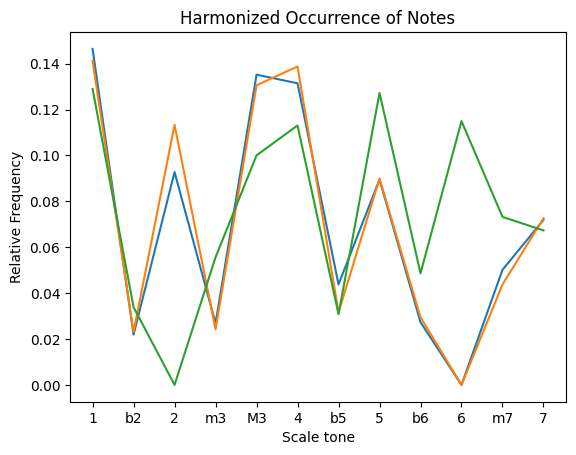

In [93]:
# show harmonic content match for two recordings of the same piece
# plot a sample file
targetfile = "MIDIextracts\\19_durs.csv"
songdurs = pd.read_csv(targetfile,dtype=float)
songdurs = songdurs["0"]
songnotes = collapse_12tones(songdurs)
songscale, keynum = recenter_12tones(songnotes)

print("Song 19 key:",tones[keynum])
fig2,ax2 = plt.subplots()
songscale, key = recenter_12tones(collapse_12tones(songdurs))
ax2.plot(scaletones,songscale)
ax2.set_title("Harmonized Occurrence of Notes")
ax2.set_xlabel("Scale tone")
ax2.set_ylabel("Relative Frequency")

# plot a sample file
targetfile = "MIDIextracts\\20_durs.csv"
songdurs = pd.read_csv(targetfile,dtype=float)
songdurs = songdurs["0"]
songnotes = collapse_12tones(songdurs)
songscale, keynum = recenter_12tones(songnotes)

print("Song 20 key:",tones[keynum])
songscale, key = recenter_12tones(collapse_12tones(songdurs))
ax2.plot(scaletones,songscale)

targetfile = "MIDIextracts\\21_durs.csv"
songdurs = pd.read_csv(targetfile,dtype=float)
songdurs = songdurs["0"]
songnotes = collapse_12tones(songdurs)
songscale, keynum = recenter_12tones(songnotes)

print("Song 21 key:",tones[keynum])
songscale, key = recenter_12tones(collapse_12tones(songdurs))
ax2.plot(scaletones,songscale)
plt.show()

In [30]:
# export scale tone prevalence "features" to CSV file
outputfile = "MIDIextracts\\song_features.csv"
#song_features.to_csv(outputfile)


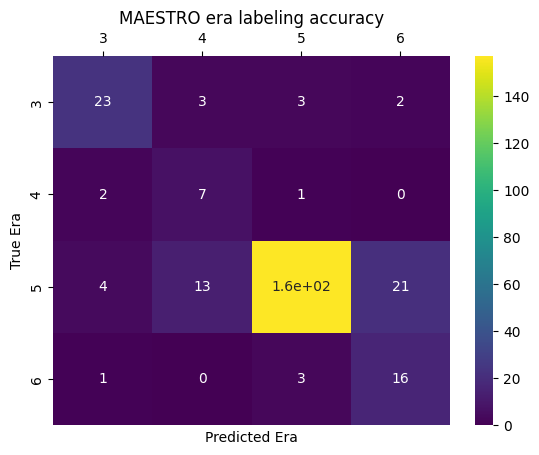

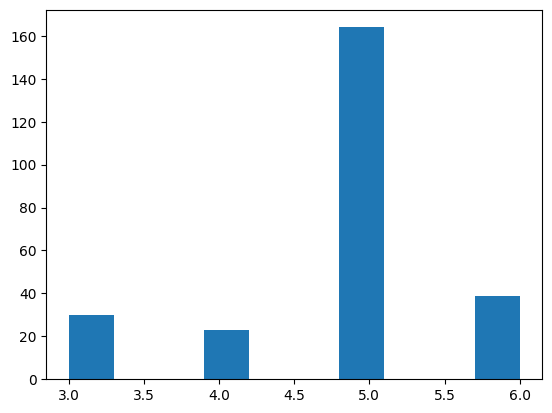

In [94]:
# show confusion matrix of Random Forest analysis
from sklearn.metrics import confusion_matrix as confmat
import seaborn as sns

cm = confmat(pred_eras,labels_test)

targetfile = "MAESTRO eras.csv"
eratable = pd.read_csv(targetfile)

ax = sns.heatmap(cm,annot=True,cmap="viridis")
#ax.set(xticklabels=eratable["Index"],yticklabels=eratable["Index"])
ax.set(xlabel="Predicted Era",ylabel="True Era")
ax.set(title="MAESTRO era labeling accuracy")
ax.xaxis.tick_top()
ax.set_xticklabels(range(3,7))
ax.set_yticklabels(range(3,7))
plt.show()

plt.hist(labels_test)
plt.show()